## Test connection - Client Worker

**Purpose** The third test consists in a container inside an instance that launch a node with 2 workers: server and client. The client request a compute sum operation in server within a shared tensor.



**Execution pipeline**:
  * Client sends data (two tensors) to server.
  * Server sends the pointer to the client.
  * Client orders operations (compute sum with the two tensors) to be computed in server (using the pointer)
  * Server executes these operations
  * Client request the data of the final result

---> *This notebook must be run in first place. We will use this notebook as a server.* 

**Reference implementation schema**:

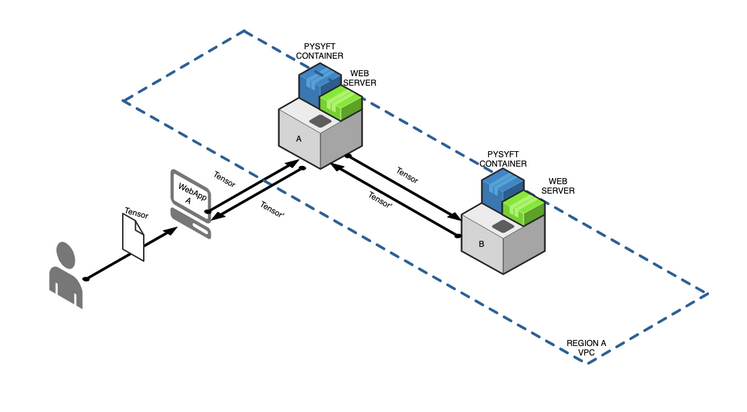

In [2]:
from IPython.display import Image
Image("./img/tensor_sum.png", width = 500, height = 100)

*Note: We do not follow exactly this implementation schema, it is simply a reference.*

### Imports 

In [3]:
import os
from pathlib import Path
from multiprocessing import Process
import syft as sy
from syft.workers.websocket_client import WebsocketClientWorker
import torch
import argparse
import logging

### Auxiliar functions

Here, we implement the following pipeline:
  * Client sends data (two tensors) to server.
  * Server sends the pointer to the client.
  * Client orders operations (compute sum with the two tensors) to be computed in server (using the pointer)
  * Server executes these operations
  * Client request the data of the final result

In [4]:
def exec_pipeline(socket_pipe):
    a = torch.tensor([1, 2, 3]).tag("a")
    b = torch.tensor([3, 2, 1]).tag("b")
    logging.info("CLIENT - Created local tensors:")
    logging.info("CLIENT - A: [{}]".format(' '.join(map(str, a.numpy()))))
    logging.info("CLIENT - B: [{}]".format(' '.join(map(str, b.numpy()))))

    a_at_server = a.send(socket_pipe)
    b_at_server = b.send(socket_pipe)
    logging.info("CLIENT - Sent tensors to remote node")

    c_at_server = a_at_server + b_at_server
    logging.info("CLIENT - Computed sum on remote node")

    c_at_local = c_at_server.get()
    logging.info("CLIENT - Get the result to local, removing from remote")
    logging.info("CLIENT - Final result: [{}]".format(' '.join(map(str, c_at_local.numpy()))))

In [5]:
def start_proc(participant, kwargs):
    """ helper function for spinning up a websocket participant """

    def target():
        socket_pipe = participant(**kwargs)
        logging.info("CLIENT - Connected")
        exec_pipeline(socket_pipe)

    p = Process(target=target)
    p.start()

    return p

### worker logging setup

We will save log data in the log_files directory in the root folder.

In [6]:
path, filename = os.path.split(os.getcwd())
log_file = os.path.join('.', 'log_files', '{}.log'.format(filename))
logging.basicConfig(filename=log_file,  format="%(asctime)s: %(message)s", datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)

### Hook initialization

A Hook is a PySyft wrapper which overrides methods on PyTorch Tensors.

In [7]:
hook = sy.TorchHook(torch)

### Create WebSocket connection

We will launch a WebSocket worker client with the following configuration:

In [8]:
node_config = {
            "id": "fed",
            "host": "0.0.0.0",
            "port": "8769",
            "hook": hook,
            "verbose": False,
             }

The WebSocket client is launched with some data

In [9]:
logging.info("CLIENT - Started in host:{}, port:{}".format(node_config['host'], node_config['port']))
start_proc(WebsocketClientWorker, node_config)

<Process(Process-1, started)>